In [1]:
%reload_ext autoreload
%autoreload 2

# Mahakala

In [380]:
import mahakala as ma
from mahakala.geodesics import Nullify, metric, get_camera_pixel, get_initial_grid, initial_condition, radius_cal
import numpy as np
import matplotlib.pyplot as plt

## Geodesic trajectories
example demo showing the geodesic trajectories for a non-spinning black hole

In [3]:
bhspin = 0.0 # the spin of the black hole, this works best for zero spin
lim = 15 # the maximum impact parameter of photons in this example
spacing = 60 # the spacing between photon impact parameters

# initialize the photons along the equator
s0 = ma.initialize_geodesics_at_camera(bhspin,60,1000,-lim,lim,spacing,camera_type='Equator')


In [4]:
# run the geodesic integrator
S,final_dt = ma.geodesic_integrator(10000,s0,40,1e-4, bhspin)
S.shape

  8%|███                                   | 818/10000 [00:01<00:19, 473.80it/s]


(819, 60, 8)

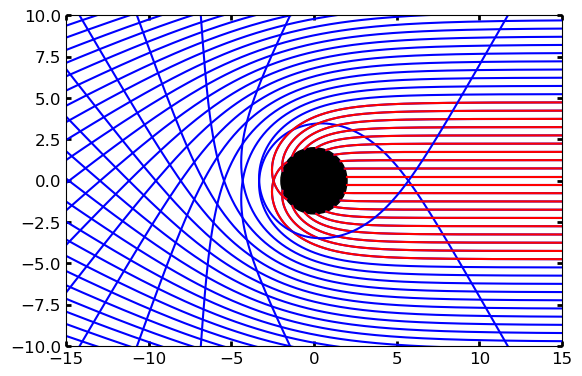

In [5]:
# make the plot of the geodesic trajectories, red photons fall into BH
for i in range(np.shape(S)[1]):
    x = S[:,i,1]
    y = S[:,i,2]
    plt.plot(x,y, c='blue')
    if np.min(np.sqrt(x*x + y*y)) < 2.01:
        plt.plot(x,y, c='red')

plt.ylim([-lim/1.5,lim/1.5])
plt.xlim([-lim,lim])
plt.gca().set_aspect('equal')
circ1 = plt.Circle((0,0), radius=2, color='k', fill=True)
plt.gca().add_patch(circ1)
plt.gca().tick_params(axis='both', which='both', labelsize=12,width=2,direction='in', right=True, top=True,color='k') 


In [343]:
import numpy as np
from tqdm import tqdm

from jax import numpy as jnp
from jax import jit, jacfwd, vmap
from jax.numpy import dot
from jax.numpy.linalg import inv
##### This will tell whether we are using CPU or GPU #########
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [391]:
def integrate_one_photon(N_time_steps, inc, angle, radius, bhspin, distance = 1000):
    s0_x, s0_v = get_camera_pixel(inc,distance,radius,angle)
    init_one   = initial_condition(s0_x, s0_v, bhspin)
    S,final_dt = ma.geodesic_integrator(N_time_steps,init_one,40,1e-2,bhspin)
    x = S[:,:,1]
    y = S[:,:,2]
    z = S[:,:,3]
    
    R = np.sqrt(x*x + y*y + z*z)
    r = np.sqrt(R*R - bhspin*bhspin + np.sqrt((R*R - bhspin*bhspin)**2 + 4.0*bhspin*bhspin*z*z))/np.sqrt(2.0)
    
    return(np.nanmin(r, axis=0)) # returns final distance from BH

In [392]:
output = integrate_one_photon(50000, 90, angles, radii, .9)
angles[45], radii[45]

(3.141592653589793, 2.823974609375)

In [413]:
n_samples = 100

angles2test = np.ones(n_samples) * np.pi
radii2test = np.linspace(2., 10., n_samples)

output_tested = integrate_one_photon(1000, 90, angles2test, radii2test, .9)

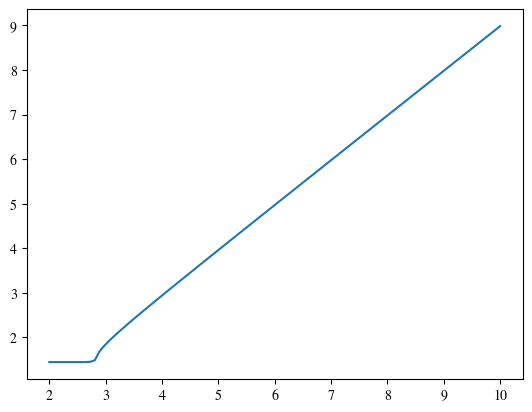

In [414]:
plt.plot(radii2test, output_tested)

In [415]:
bhspin = 0.9
N_time_steps = 4000
s0_x, s0_v = get_camera_pixel(90, 1000, radii2test, angles2test)
init_one   = initial_condition(s0_x, s0_v, bhspin)
S,final_dt = ma.geodesic_integrator(N_time_steps,init_one,40,1e-4, bhspin)
x = S[:,:,1]
y = S[:,:,2]
z = S[:,:,3]

(-10.0, 10.0)

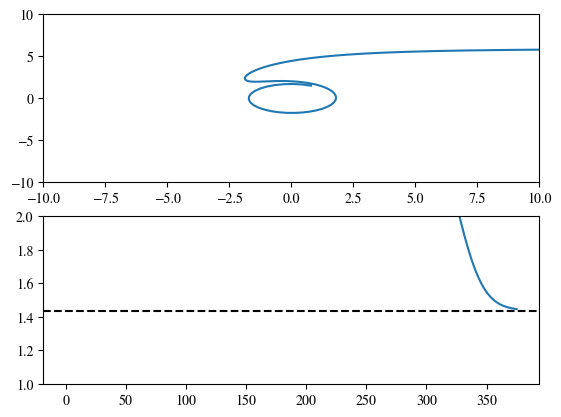

In [410]:
s0_x, s0_v = get_camera_pixel(90, 1000, np.ones(2)*6., np.ones(2)*0.)
init_one   = initial_condition(s0_x, s0_v, bhspin)
S,final_dt = ma.geodesic_integrator(N_time_steps,init_one,40,1e-2, bhspin)

r = radius_cal(S[:, 0], bhspin)

x = S[:, 0, 1]
y = S[:, 0, 2]
z = S[:, 0, 3]

ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

ax2.plot(r)
ax2.set_ylim(1, 2)
ax2.axhline(y=1. + np.sqrt(1.-bhspin*bhspin), ls='--', color='k')

ax1.plot(x, y)
plim = 10
ax1.set_xlim(-plim, plim)
ax1.set_ylim(-plim, plim)

In [397]:
S.shape

(376, 2, 8)

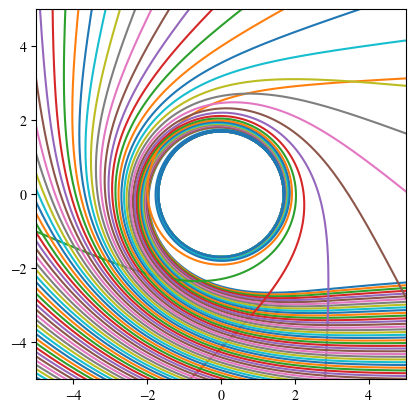

In [416]:
plt.plot(x, y)
plim = 5
plt.xlim(-plim, plim)
plt.ylim(-plim, plim)
plt.gca().set_aspect('equal')

In [401]:
output = integrate_one_photon(1000, 90, 0.01, 6.522, .9)
print(output)
output = integrate_one_photon(1000, 90, 0.01, 6.5225, .9)
print(output)
output = integrate_one_photon(1000, 90, 0.01, 6.5225, .9)
output

[1.4451768]
[1.44523]


array([1.44523], dtype=float32)

array([1.44523], dtype=float32)

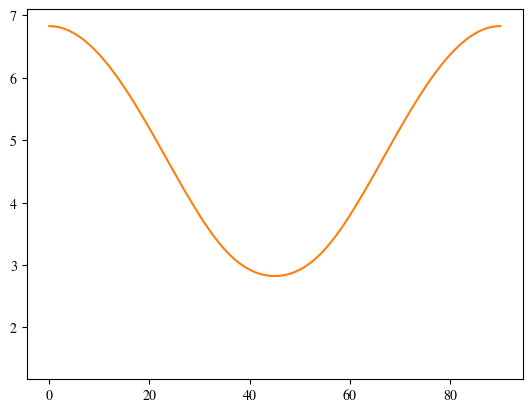

In [402]:
np.shape(output)
plt.plot(output)
plt.plot(radii)
output

In [420]:
def bisection_shadow_par(bhspin, inc, num_angles, N_time_steps=2000, uncertainty_allowed=0.001, max_it=40):
    inner  = np.zeros(num_angles) + 0.5
    outer  = np.zeros(num_angles) + 10
    error  = outer - inner
    angles = np.arange(num_angles)/num_angles*2.*np.pi
    
    reh = 1. + np.sqrt(1. - bhspin*bhspin)
    reh = reh + 0.05
    
    #reh = reh + 0.5
    
    counter = 0
    while (np.max(error) > uncertainty_allowed) and (counter < max_it):
        final_mid       = integrate_one_photon(N_time_steps, inc, angles, (outer-inner)/2+inner, bhspin)
        fell            = np.where(final_mid < reh)
        got_away        = np.where(final_mid > reh)
        inner[fell]     = (outer[fell]-inner[fell])/2+inner[fell]
        outer[got_away] = (outer[got_away]-inner[got_away])/2+inner[got_away]
        error = outer - inner
        counter+=1
        
    angles2              = np.zeros(num_angles+1)
    angles2[:num_angles] = angles
    angles2[num_angles]  = angles[0]
    inner2               = np.zeros(num_angles+1)
    inner2[:num_angles]  = inner
    inner2[num_angles]   = inner[0]
    return(angles2, inner2)

In [423]:
num_angles = 90

results = np.zeros((2, num_angles))
bhspin  = 0.5
inc     = 37.0
angles, radii = bisection_shadow_par(bhspin, inc, num_angles)

/Users/lia/Dropbox/research/master_code/my_plot.py:61: RuntimeWarning: invalid value encountered in sqrt
  return(coef_in_front*np.sqrt(first_part+second_part+third_part))


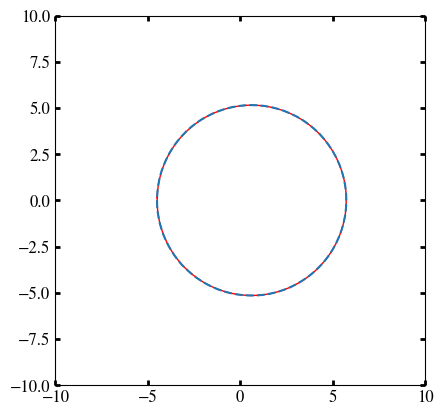

In [424]:
plt.plot(radii*np.cos(angles), radii*np.sin(angles),'--', zorder=42)

lim = 10
plt.ylim([-lim,lim])
plt.xlim([-lim,lim])
plt.gca().set_aspect('equal')
plt.gca().tick_params(axis='both', which='both', labelsize=12,width=2,direction='in', right=True, top=True,color='k') 
make_circle_kerr(plt.gca(),bhspin,i=inc)
#plt.scatter(6.5225*np.cos(0.01), 6.5225*np.sin(0.01))


# 0.01, 6.522

In [224]:
import sys
import os
from os.path import expanduser
home = expanduser("~")
sys.path.append(os.path.abspath(home+'/Dropbox/research/master_code'))
from my_plot import * 

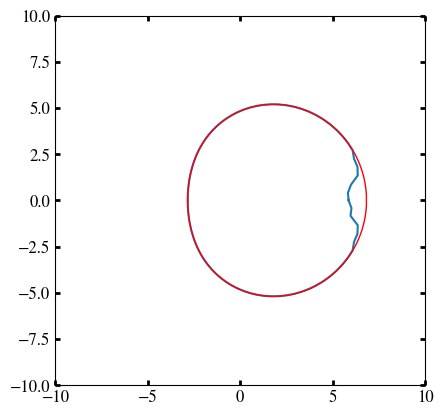

In [226]:
num_angles = 9

results = np.zeros((2, num_angles))
bhspin = 0.9
inc = 90.0
spacing_angles = 360/num_angles
k = 0
for angle in np.arange(num_angles)*40:
    rad = bisection_shadow(bhspin, inc, angle/180.*np.pi)
    results[0,k] = angle/180.*np.pi
    results[1,k] = rad
    k+=1
    

IndexError: tuple index out of range

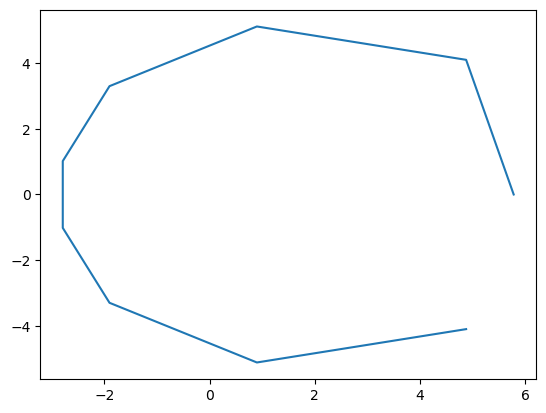

In [64]:
plt.plot(results[1,:]*np.cos(results[0,:]), results[1,:]*np.sin(results[0,:]))


In [69]:
distance = bisection_shadow(0.0, 0.0)
distance

cpu


TypeError: bisection_shadow() missing 1 required positional argument: 'angle'

In [51]:
integrate_one_photon(1000, 0.001, 0.001, 0.001)

[[ 0.000000e+00  0.000000e+00  1.000000e-03  1.001000e+03  1.000000e+00
   7.063989e-01 -7.063989e-01  7.063990e-04]]


  4%|█▌                                     | 39/1000 [00:00<00:00, 2464.41it/s]


0.001

## Shadows
example demo of generating a few Kerr shadows for different inclinations and spins

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1)

inc = 30
for a in [0,.3,.5,.7,.9]:
    radii, phi = kerr_shadow(a, inc)
    x = radii*np.cos(phi)
    y = radii*np.sin(phi)
    ax1.plot(x,y, label = r'$a=$'+str(a))
ax1.legend(frameon=False)


for inc in [0,30,60,90]:
    radii, phi = kerr_shadow(a, inc)
    x = radii*np.cos(phi)
    y = radii*np.sin(phi)
    ax2.plot(x,y, label = r'$i=$'+str(inc))
ax2.legend(frameon=False)



## Analytic Accretion Model
example demo of generating an image of an accretion flow based on an analytic accretion model

In [ ]:
# Take in initial parameters, camera position, and parameters

grid_photons = make_grid_photons(inclination_angle, spin, distance)

my_geodesics = geodesics(grid_photons, inclination_angle, spin, distance)

fluid = get_fluid_grid(GRMHD or analytic?)

image = synemiss(my_geodesics, R_high, R_low, Mscale, fluid, ...)

## Simulation Image
example demo of generating an image based on an example GRMHD snapshot

In [74]:
s0_x, s0_v = get_camera_pixel(60,1000,np.arange(5),np.arange(5)/5*np.pi)
s0_x, s0_v

(Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00],
        [ 8.6602539e+02,  8.6573151e+02,  8.6507434e+02,  8.6459882e+02,
          8.6484979e+02],
        [ 0.0000000e+00,  8.0901700e-01,  6.1803401e-01, -9.2705101e-01,
         -3.2360680e+00],
        [ 5.0000000e+02,  5.0050903e+02,  5.0164728e+02,  5.0247092e+02,
          5.0203613e+02]], dtype=float32),
 Array([[ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00,  1.0000000e+00,
          1.0000000e+00],
        [ 0.0000000e+00,  8.6601776e-01,  3.4641099e+00,  7.7942338e+00,
          1.3856383e+01],
        [ 0.0000000e+00,  1.7449260e-05,  1.0926276e-05,  7.7927485e-05,
         -2.5075674e-04],
        [ 0.0000000e+00,  4.9997973e-01,  2.0000148e+00,  4.5000429e+00,
          7.9999242e+00]], dtype=float32))